# DenseNet

찐막

In [1]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

# 폴더 이동
%cd drive/My\ Drive/ai-school/CXR-pjt
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ai-school/CXR-pjt
/content/drive/My Drive/ai-school/CXR-pjt


In [2]:
from tensorflow.keras.applications.densenet import DenseNet201, DenseNet169
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf 
import numpy as np 
import glob as gb
import cv2
import os

In [3]:
# 하이퍼파라미터
# epochs = 50

image_size = 224
LABELS = {'PNEUMONIA': 0, 'NORMAL': 1, 'COVID19': 2}

In [4]:
# path 설정 
path_data = "./data_sample"

path_PNEUMONIA = path_data + "/PNEUMONIA"
path_NORMAL = path_data + "/NORMAL"
path_COVID19 = path_data + "/COVID"

In [5]:
len_PNEUMONIA = len(os.listdir(path_PNEUMONIA))
len_NORMAL = len(os.listdir(path_NORMAL))
len_COVID = len(os.listdir(path_COVID19))

print(len_PNEUMONIA)
print(len_NORMAL)
print(len_COVID)

print("total: ", len_COVID + len_NORMAL + len_PNEUMONIA)

1000
1000
1000
total:  3000


In [6]:
# 학습 및 검증 데이터용 ImageDataGenerator 생성해 놓기 
train_datagen = ImageDataGenerator(rescale=1./255., 
                                #    horizontal_flip = True, 
                                #    shear_range = 0.2,
                                #    zoom_range = 0.2,
                                #    width_shift_range = 0.2,
                                #    height_shift_range = 0.2,
                                   validation_split = 0.25)

#검증데이터는 정규화 외에 따로 조정 없음 
valid_datagen = ImageDataGenerator(rescale=1./255., 
                                   validation_split = 0.25)

#flow_from_directory()는 앞서 배운 flow()와 비슷, 단 경로를 통채로 가져올 수 있음 
train_generator = train_datagen.flow_from_directory(directory = path_data, #저장 경로 
                                                    subset = 'training',   
                                                    batch_size = 1,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))

valid_generator = valid_datagen.flow_from_directory(directory = path_data,
                                                    subset = 'validation',
                                                    batch_size = 1,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


In [7]:
def getCode(label):
    return LABELS[label]

def getLabel(n):
    for key, val in LABELS.items():
        if n == val:
            return key

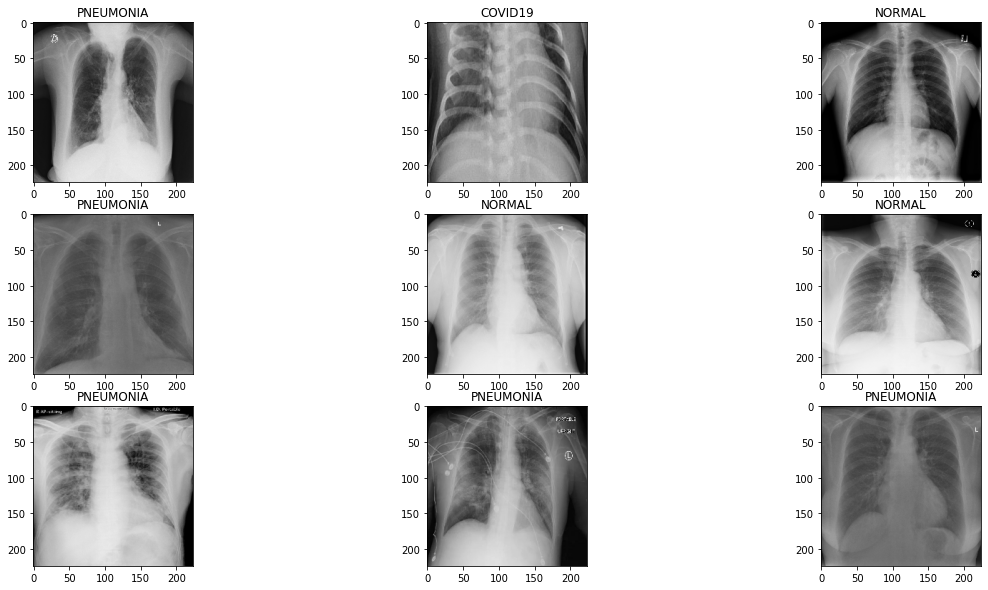

In [8]:
plt.figure(figsize=(20,10))
lst = [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600]
cnt = 1
for i in lst:
    plt.subplot(3, 3, cnt)
    plt.imshow(train_generator.__getitem__(i)[0][0])
    plt.title(getLabel(np.argmax(train_generator.__getitem__(i)[1])) )
    cnt += 1
plt.show()

### 아래 모델 부분은 진균이꺼 참고함

In [9]:
base_model = DenseNet201(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)
# base_model = DenseNet169(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

# base_model.trainable = False

In [10]:
# base_model.summary()

In [11]:
base_model.save("base_model.h5")

In [12]:
train_features = []
train_Y = []

for idx in tqdm(range(train_generator.n)):
    x, y = train_generator.next()
    train_Y.extend(y)
    feature = base_model.predict(x)
    train_features.extend(feature)


train_features = np.array(train_features)
train_Y = np.array(train_Y)

print(train_features.shape)
print(train_Y.shape)

100%|██████████| 2250/2250 [02:58<00:00, 12.63it/s]


(2250, 7, 7, 1920)
(2250, 3)


In [13]:
valid_features = []
valid_Y = []

for idx in tqdm(range(valid_generator.n)):
    x, y = valid_generator.next() 
    valid_Y.extend(y) 
    feature = base_model.predict(x)
    valid_features.extend(feature)


valid_features = np.array(valid_features)
valid_Y = np.array(valid_Y)

print(valid_features.shape)
print(valid_Y.shape)

100%|██████████| 750/750 [00:55<00:00, 13.57it/s]


(750, 7, 7, 1920)
(750, 3)


In [14]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input

In [15]:
# from tensorflow.keras.layers import Input
# Make Classifier Model
def create_model():
    input = tf.keras.layers.Input(shape=base_model.output.shape[1:])

    x = GlobalAveragePooling2D()(input)

    x = Dense(512, activation='relu')(x)

    x = tf.keras.layers.Dropout(0.4)(x)

    predictions = Dense(3, activation='softmax')(x)

    model = Model(inputs=input, outputs=predictions)
    model.compile(tf.optimizers.RMSprop(0.0001), 
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])
    return model

In [16]:
# 모델 객체를 만듬
model = create_model()

checkpoint_path = 'ckp'

cp = ModelCheckpoint(filepath=checkpoint_path,
                                save_weights_only=True,
                                save_best_only=True,
                                monitor='val_accuracy',
                                verbose=1)

es = EarlyStopping(patience=50, verbose=1)
history = model.fit(train_features, train_Y, 
                    validation_data=(valid_features, valid_Y),
                    epochs = 100,
                    batch_size = 1,
                    callbacks=[es,cp])


Epoch 1/100
2246/2250 [============================>.] - ETA: 0s - loss: 0.3382 - accuracy: 0.8642
Epoch 00001: val_accuracy improved from -inf to 0.92400, saving model to ckp
2250/2250 [==============================] - 6s 3ms/step - loss: 0.3396 - accuracy: 0.8640 - val_loss: 0.2195 - val_accuracy: 0.9240
Epoch 2/100
2234/2250 [============================>.] - ETA: 0s - loss: 0.2141 - accuracy: 0.9279
Epoch 00002: val_accuracy improved from 0.92400 to 0.93333, saving model to ckp
2250/2250 [==============================] - 6s 3ms/step - loss: 0.2127 - accuracy: 0.9284 - val_loss: 0.2027 - val_accuracy: 0.9333
Epoch 3/100
2246/2250 [============================>.] - ETA: 0s - loss: 0.1983 - accuracy: 0.9372
Epoch 00003: val_accuracy improved from 0.93333 to 0.95067, saving model to ckp
2250/2250 [==============================] - 6s 3ms/step - loss: 0.2000 - accuracy: 0.9369 - val_loss: 0.1701 - val_accuracy: 0.9507
Epoch 4/100
2238/2250 [============================>.] - ETA: 0s - 

In [17]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7, 7, 1920)]      0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               983552    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 985,091
Trainable params: 985,091
Non-trainable params: 0
_________________________________________________________________


In [18]:
mymodel = create_model()

# 가중치 로드
mymodel.load_weights(checkpoint_path)

# 모델 평가
print(mymodel.evaluate(valid_features, valid_Y))

24/24 [==============================] - 0s 6ms/step - loss: 0.2385 - accuracy: 0.9600
[0.23854823410511017, 0.9599999785423279]


In [19]:
mymodel.save('DenseNet_model.h5')

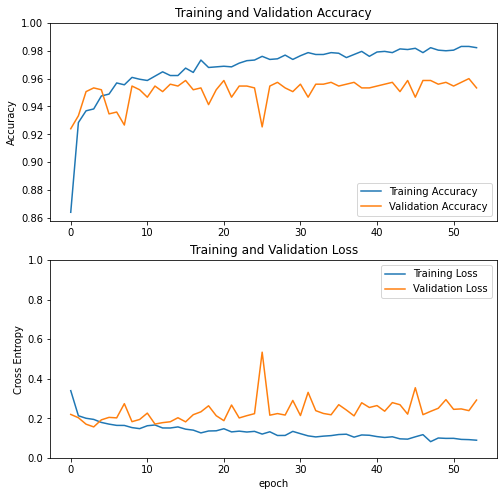

In [20]:
# 학습 곡선
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
base_pred = base_model.predict(valid_generator)

In [22]:
pred = mymodel.predict(base_pred)

In [23]:
len(pred)

750

In [24]:
y_test=[]
for i in tqdm(range(750)):
    y_test.extend(valid_generator.__getitem__(i)[1])

print(len(y_test))
y_test = np.array(y_test)

y_test=np.argmax(y_test, axis=1)
y_pred= np.argmax(pred, axis=1)

print("pred: ",len(y_pred))
print("y_test: ",len(y_test))

100%|██████████| 750/750 [00:09<00:00, 76.59it/s]

750
pred:  750
y_test:  750


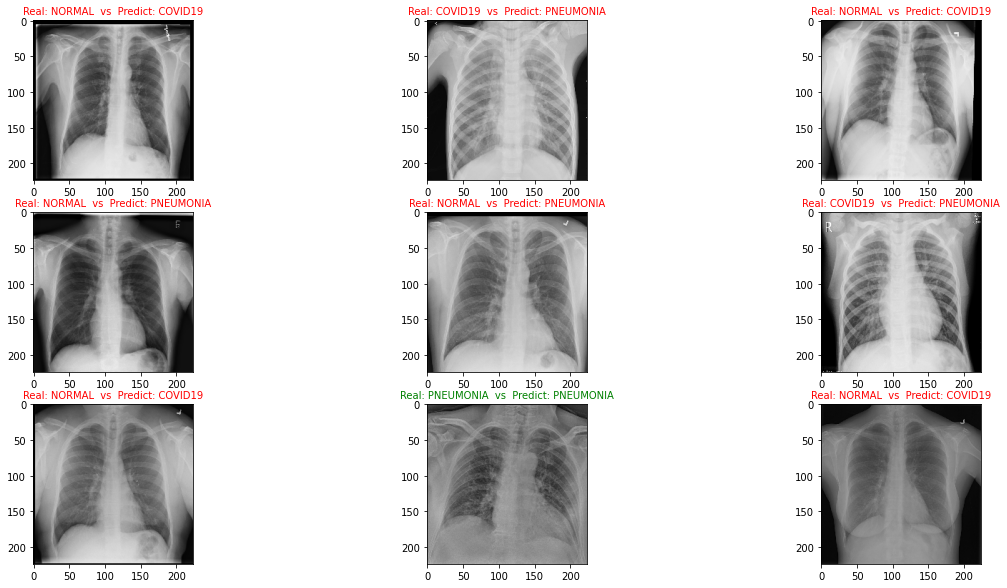

In [25]:
plt.figure(figsize=(20,10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(valid_generator.__getitem__(i)[0][0], cmap='gray')
    color = "green" if y_test[i] == y_pred[i] else "red"
    plt.title(f"Real: {getLabel(y_test[i])   }  vs  Predict: {getLabel(y_pred[i])}", color=color, fontsize=10)
plt.show()

In [26]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_pred, y_test)

print(cm)

[[88 70 92]
 [89 83 82]
 [73 97 76]]


In [27]:
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[88 70 92]
 [89 83 82]
 [73 97 76]]


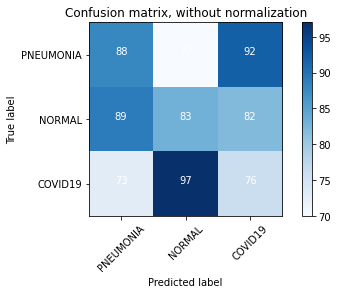

In [28]:
plt.figure()
plot_confusion_matrix(cm, classes=LABELS.keys(), title='Confusion matrix, without normalization')